In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [40]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [42]:
# Set colour palette
custom_palette = ["#04364A", "#176B87", "#64CCC5", "#DAFFFB"]

In [43]:
df=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [44]:
df.shape,test.shape

((27481, 4), (3534, 3))

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [46]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [47]:
df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [48]:
test.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [49]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

test.dropna(inplace=True)
test.reset_index(drop=True, inplace=True)

In [50]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [51]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


<ipython-input-52-66898696394d>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df,x="sentiment",palette=custom_palette)
<ipython-input-52-66898696394d>:1: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.countplot(data=df,x="sentiment",palette=custom_palette)


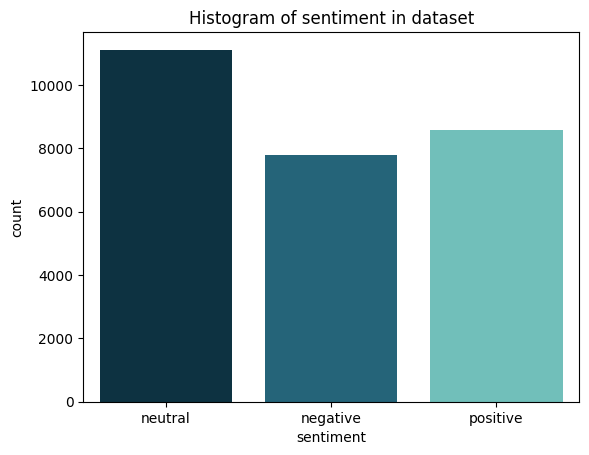

In [52]:
sns.countplot(data=df,x="sentiment",palette=custom_palette)
plt.xlabel("sentiment")
plt.ylabel("count")
plt.title("Histogram of sentiment in dataset")
plt.show()

# Data Preprocessing

In [53]:
corpus_d=df['text']
corpus_t=test['text']

In [54]:
def removelinks(corpus):
  for i in range (0,len(corpus)):
    corpus[i] = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", corpus[i])
    return corpus



In [55]:
corpus_d = removelinks(corpus_d)
corpus_t = removelinks(corpus_t)

Remove stop words and perform lemmatization

In [56]:
 import nltk
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
stop_words=set(stopwords.words('english'))
stop_words.remove('not')

In [58]:
lm=WordNetLemmatizer()


In [59]:

def performOperations(review):
    sentences = review.split('. ')  # Splitting the review into sentences (assuming sentences are separated by '. ')
    processed_review = []
    for sentence in sentences:
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)  # Removing everything except alphabets
        sentence = sentence.lower()
        sentence = sentence.split()  # Splitting into words
        processed_review.append(' '.join(sentence))  # Rejoining the words into a sentence
    return '. '.join(processed_review)  # Rejoining sentences into the final processed review


In [60]:


filtered_corpus_d = []
for review in corpus_d:
    filtered_corpus_d.append(performOperations(review))

filtered_corpus_t = []
for review in corpus_t:
    filtered_corpus_t.append(performOperations(review))



In [61]:
filtered_corpus_t

['last session of the day',
 'shanghai is also really exciting precisely skyscrapers galore. good tweeps in china sh bj',
 'recession hit veronique branquinho she has to quit her company such a shame',
 'happy bday',
 'http twitpic com w p i like it',
 'that s great weee visitors',
 'i think everyone hates me on here lol',
 'soooooo wish i could but im in school and myspace is completely blocked',
 'and within a short time of the last clue all of them',
 'what did you get my day is alright. haven t done anything yet. leaving soon to my stepsister though',
 'my bike was put on hold should have known that. argh total bummer',
 'i checked. we didn t win',
 '. and you re on twitter did the tavern bore you that much',
 'i m in va for the weekend my youngest son turns tomorrow it makes me kinda sad he is getting so big check out my twipics',
 'its coming out the socket i feel like my phones hole is not a virgin. that s how loose it is. ',
 'so hot today don t like it and i hate my new timeta

In [62]:
def getUniqueWords(sentences):

    # Initialize a defaultdict to store word counts
    word_counts = defaultdict(int)

    # Tokenize each sentence and update word counts
    for sentence in sentences:
        words = word_tokenize(sentence.lower()) # Convert to lowercase for case insensitivity
        for word in words:
            word_counts[word] += 1

    return dict(word_counts)

In [63]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
# Vocabulary

vocabulary_d = getUniqueWords(filtered_corpus_d)
vocabulary_t = getUniqueWords(filtered_corpus_t)

In [64]:
# Sort the dictionary by values in descending order
vocabulary_d = dict(sorted(vocabulary_d.items(), key=lambda item: item[1], reverse=True))
vocabulary_t = dict(sorted(vocabulary_t.items(), key=lambda item: item[1], reverse=True))

In [65]:
def plotUniqueWords(vocabulary):
    df = pd.DataFrame(vocabulary.items(), columns=['Word', 'Frequency'])
    # Sort the DataFrame by frequency
    df = df[0:50].sort_values(by='Frequency', ascending=False)

    # Plotting with Seaborn
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Word', y='Frequency', data=df, palette=custom_palette)
    plt.xticks(rotation=90)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Word Frequency in the Dictionary')
    plt.tight_layout()
    plt.show()

<ipython-input-65-ab36c6a22ad9>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=df, palette=custom_palette)
<ipython-input-65-ab36c6a22ad9>:8: UserWarning: 
The palette list has fewer values (4) than needed (50) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Word', y='Frequency', data=df, palette=custom_palette)


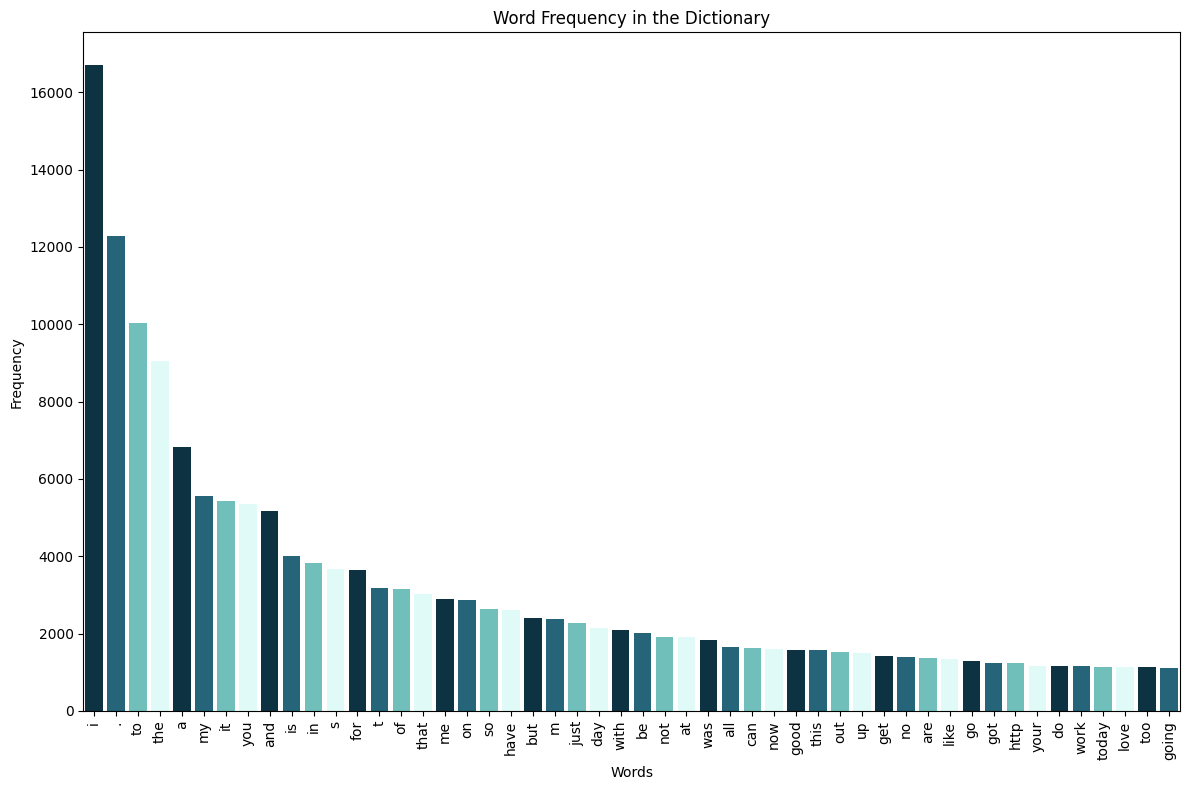

In [66]:
# Plot dataset vocabulary
plotUniqueWords(vocabulary_d)

In [67]:
# Create a dataframe
dataframe = pd.DataFrame(filtered_corpus_d, columns=["Sentence"])
testframe = pd.DataFrame(filtered_corpus_t, columns=["Sentence"])

# Append the dependant variable
dataframe["Sentiment"] = df["sentiment"]
testframe["Sentiment"] = test["sentiment"]

# Encode the sentiment variable
label_encoder = LabelEncoder()
dataframe['SentimentEncoded'] = label_encoder.fit_transform(dataframe['Sentiment'])
testframe['SentimentEncoded'] = label_encoder.transform(testframe['Sentiment'])

In [68]:
dataframe


,Sentence,Sentiment,SentimentEncoded
0,i d have responded if i were going,neutral,1
1,sooo sad i will miss you here in san diego,negative,0
2,my boss is bullying me,negative,0
3,what interview leave me alone,negative,0
4,sons of why couldn t they put them on the rele...,negative,0
...,...,...,...
27475,wish we could come see u on denver husband los...,negative,0
27476,i ve wondered about rake to. the client has ma...,negative,0
27477,yay good for both of you. enjoy the break you ...,positive,2
27478,but it was worth it,positive,2


# Training

In [69]:
testframe = testframe.dropna(subset=['Sentence'])


In [70]:
# Using Random Forrest Classifier

clf = Pipeline([
('vectorizer_tfidf', TfidfVectorizer()),
( 'RandomForest', RandomForestClassifier(n_estimators=20, criterion="entropy", random_state=0))
])

clf.fit(dataframe['Sentence'].tolist(), dataframe['SentimentEncoded'].tolist())

y_pred = clf.predict(testframe['Sentence'].tolist())

In [71]:
print(classification_report(testframe['SentimentEncoded'].tolist(),y_pred))


              precision    recall  f1-score   support

           0       0.69      0.57      0.62      1001
           1       0.60      0.74      0.66      1430
           2       0.78      0.65      0.71      1103

    accuracy                           0.67      3534
   macro avg       0.69      0.66      0.67      3534
weighted avg       0.68      0.67      0.67      3534



Using Random Forest Classifier we have performed natural language processing and predicted sentiments of user while making these remarks with a acuuracy of 70%, this project can be used in online e-commerce to filter our negative and positive responses on a product.